# The Analyst of Environmentalists Group
This notebook aims to support decision-making under deep uncertainty of the Ijssel River problem with the spirit to protect and sustain biodiversity and ecological system (environmental ethic). The problem is a multi-objective problem to develop a flood risk management plan take into account protection and mitigation measures.

To cater well the deep uncertainty, the policy are evaluated using Multi-Objective Robust Decision Making (MORDM). Hence, the proposed policy are acquired through four main steps:
1. Establish problem formulation
2. Searching for candidate policy
3. Explore the effects of uncertainties
4. Scenario discovery

In [2]:
from ema_workbench.em_framework.evaluators import perform_experiments

from ema_workbench import (
    Model,
    Policy,
    MultiprocessingEvaluator,
    SequentialEvaluator,
    ScalarOutcome,
    IntegerParameter,
    optimize,
    Scenario,
)

from ema_workbench import save_results, load_results
from ema_workbench.em_framework.optimization import (EpsilonProgress,
                                                     ArchiveLogger)
from ema_workbench import Constraint
from ema_workbench.util import ema_logging
from ema_workbench.analysis import dimensional_stacking, parcoords
from ema_workbench import Scenario
from ema_workbench.analysis import prim

from problem_formulation import get_model_for_problem_formulation

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd

import os
import shutil

# 1| Establish problem formulation

The Rijkswaterstaat proposed three policy options to tackle the Ijssel river flood problem. The three policy options are:
(1) **Room for the River (RfR)**, this can benefit the environment by enhancing habitats for wildlife, improving water quality, and restoring natural river processes.
(2) **Dike heightening** believed to be effective at reducing the flood risk. However, it can provide negative impact to the environment, such as disrupt river ecosystem and reduce the quality of wildlife habitats. Lastly,
(3) **Early Warning System** as the preventive measure to avoid deaths.

Environmentalist group is strongly support the Room for the River solution in the upstream level. Hence, it will be considered as a constraint in step **## 2.3 | Acquired candidate solutions for the reference scenario**. Additionally, the actors have agreed to consider in minimising cost and causalities. So the direction of the outcome of interest can was altered as the environmentalist group interest in:
- Disaggregated Expected Annual Damage over Dike Rings: minimize
- Disaggregated Expected Number of Deaths over Dike Rings: minimize
- Disaggregated Dike Investment Costs over Dike Rings: minimize
- RfR Total Costs : minimize
- Expected Evacuation Costs: minimize

The direction of the outcome is translated as problem formulation 7 in *`problem_formulation.py`* file.

In [3]:
ema_logging.log_to_stderr(ema_logging.INFO)

#establish model with problem formulation 7
# you can select from problem formulation from 0 to 7
# the detailed of the problem formulation is in the `problem_formulation.py` file
dike_model, planning_steps = get_model_for_problem_formulation(7)

# 2| Searching for candidate policy

## 2.1| Run do nothing experiments
Do nothing policy is the baseline condition, which does not implement any measures. This is applied to ensure that the scenarios only covers the combination of the uncertainties and not the policy levers, assuming that initial condition is no policy levers applied.

In [148]:
# create function to get no policy scenarios in EMA Workbench
def get_do_nothing_dict():
    return {l.name: 0 for l in dike_model.levers}

policy1 = Policy("Policy 1", **get_do_nothing_dict())

In [ ]:
# Pass the policies list and run the experiments
# since it is a do nothing policy, all problem formulation works
n_scenarios = 5000
with MultiprocessingEvaluator(dike_model) as evaluator:
    results = evaluator.perform_experiments(n_scenarios, policy1)

In [ ]:
# save the results
experiments, outcomes = results

In [ ]:
# export results to have a reproducible results
# save_results((experiments, outcomes), './archive/results_do_nothing_2.tar.gz')


### Explore scenario coverage
To ensure the initial scenario shows the most favorable which represent the population of the uncertainties combination, scenario coverages are displayed. The coverage is represented by reducing the blank space and.

In [149]:
# load results from the previous experiments
experiments, outcomes = load_results('./archive/results_do_nothing_2.tar.gz')
experiments

In [150]:
# transform the outcomes array to panda dataframe
outcomes = pd.DataFrame(outcomes)

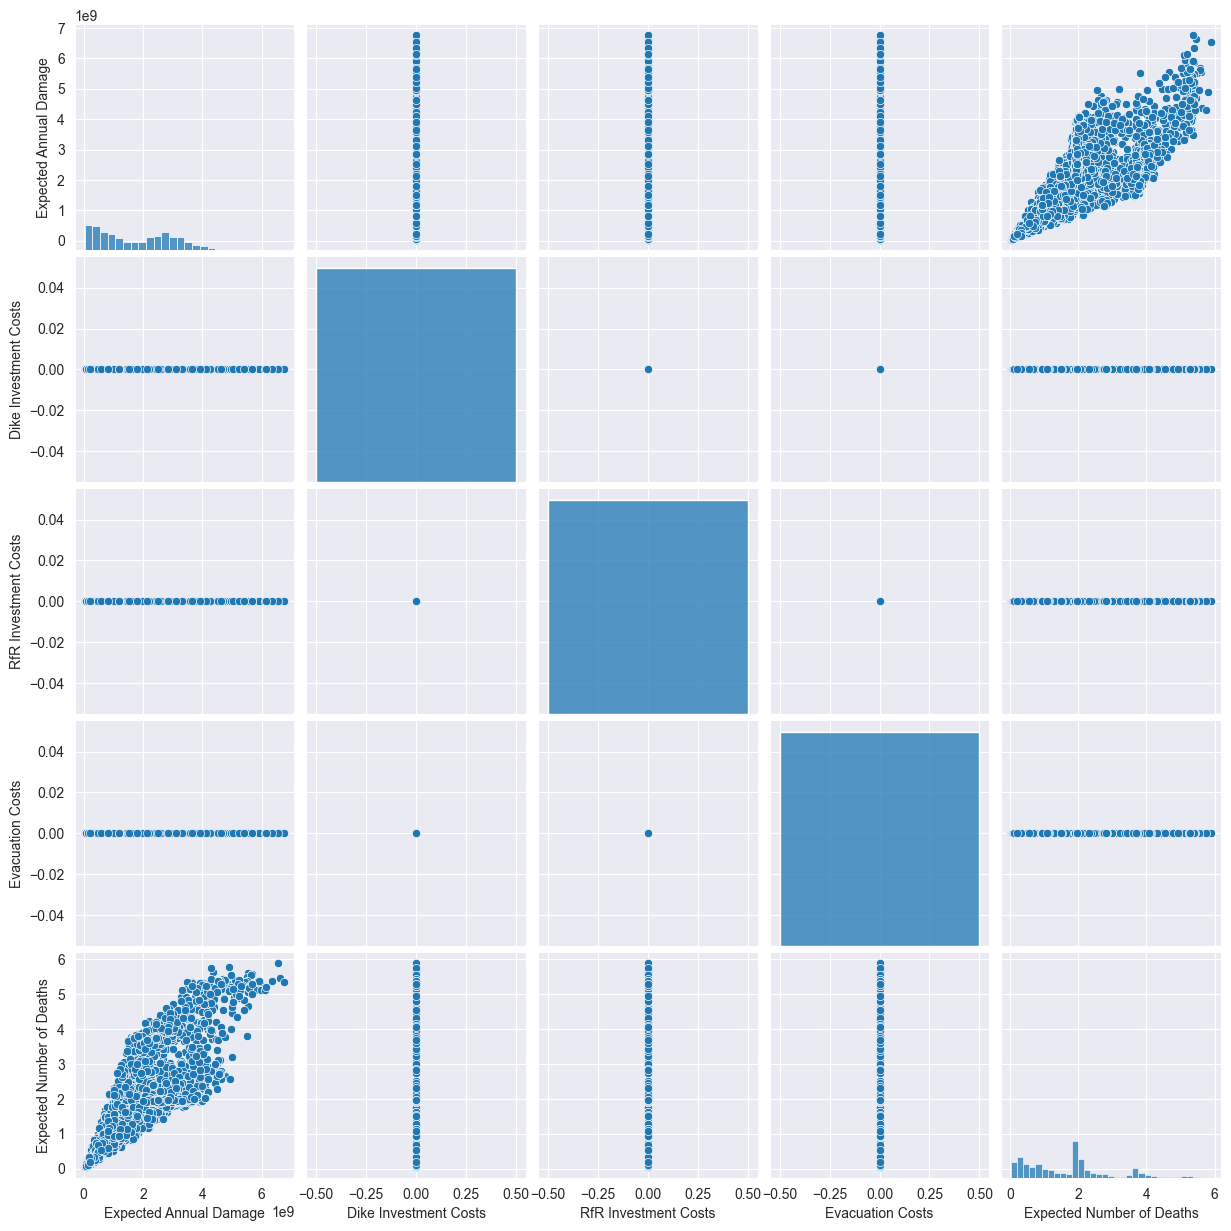

In [6]:
# pairplot to see the relationship between the outcomes
sns.pairplot(pd.DataFrame.from_dict(outcomes))
plt.show()

In [151]:
# drop the levers and unnecessary columns to analyse the coverage
# drop the levers
cleaned_experiments = experiments.drop(labels=[l.name for l in dike_model.levers], axis=1)
# drop the unnecessary attribute
cleaned_experiments.drop(columns= ['scenario', 'policy', 'model'], inplace= True)
# show the dataframe
cleaned_experiments

In [152]:
# check the coverage of the scenarios
# set the preferred direction of the outcomes
# in this case 5% of the highest values
# 95th percentile of the worst outcome

# example for Expected Number of Deaths
data_deaths = outcomes['Expected Number of Deaths']
y_deaths = data_deaths > np.percentile(data_deaths, 95)
y_deaths = np.array(y_deaths)

# example for Expected Number of Damages
data_damages = outcomes['Expected Annual Damage']
y_damages = data_damages > np.percentile(data_damages, 95)
y_damages = np.array(y_damages)

# example for Expected Number of RfR Investment Costs
data_rfr = outcomes['RfR Investment Costs']
y_rfr = data_rfr > np.percentile(data_rfr, 95)
y_rfr = np.array(y_rfr)

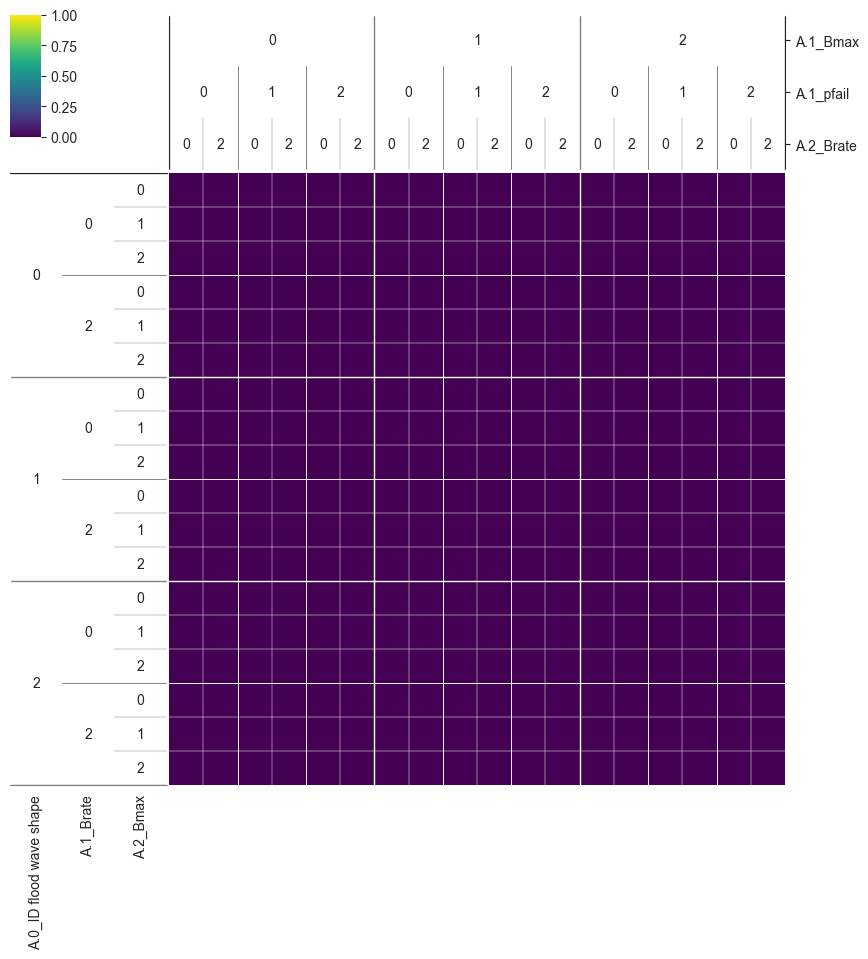

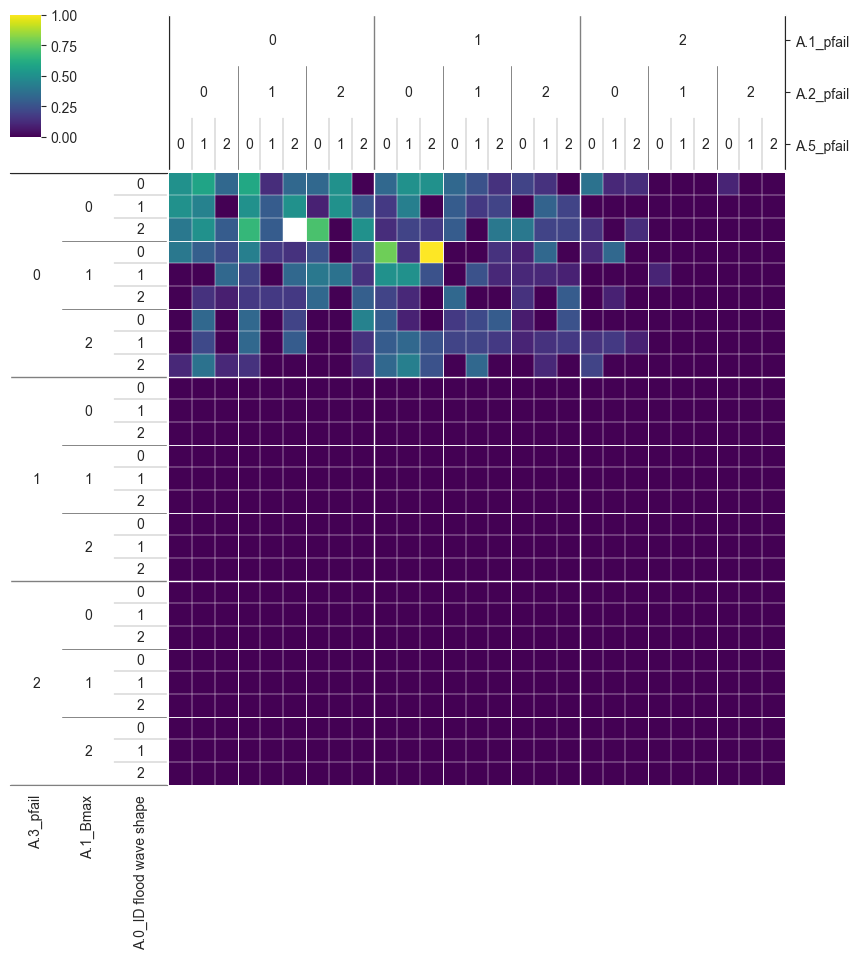

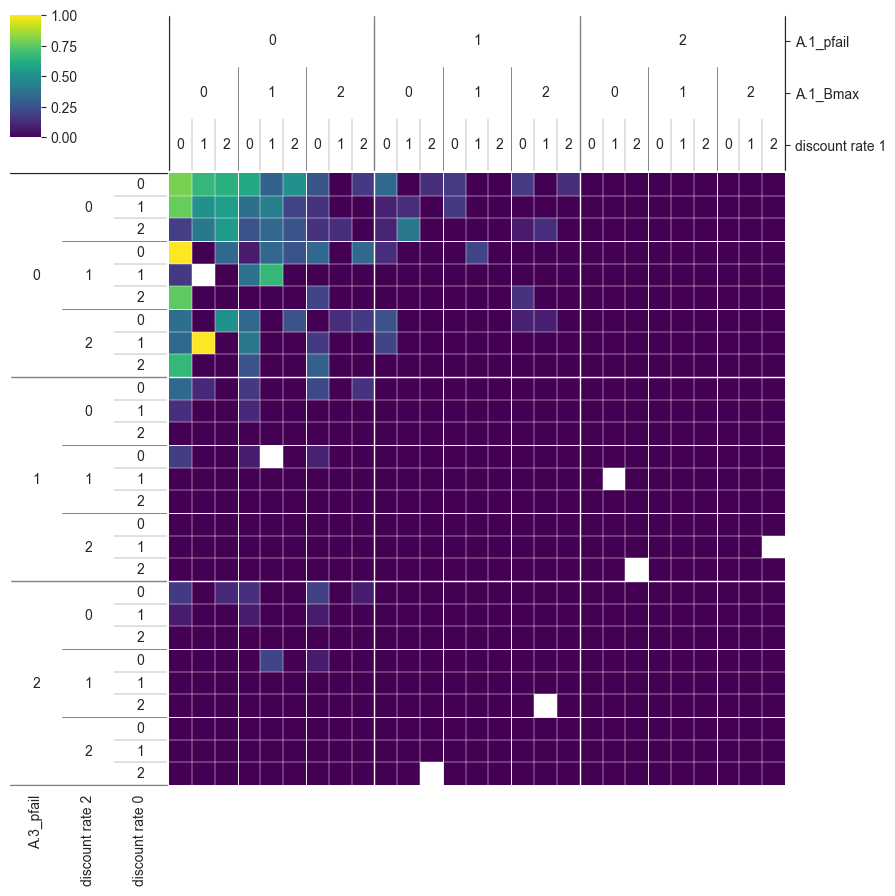

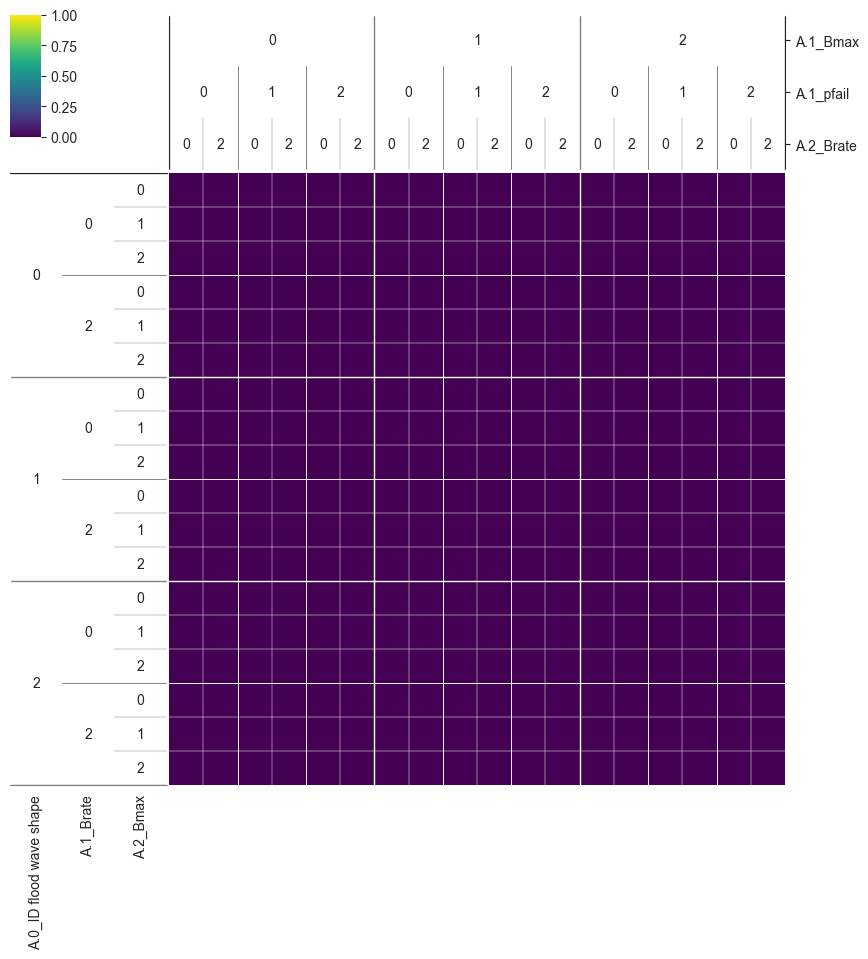

In [9]:
# create the pivot plot
dimensional_stacking.create_pivot_plot(cleaned_experiments, y_deaths)
dimensional_stacking.create_pivot_plot(cleaned_experiments, y_damages)
dimensional_stacking.create_pivot_plot(cleaned_experiments, y_rfr)

The coverage of the scenario is shown in the pivot plot above. The blank space in the pivot plot shows the scenario that has not been covered by the experiments. With 5000 scenarios, the pivot plot shows that the scenario coverage is not sufficient to represent the uncertainties space. However, as the candidate solutions will be evaluated further in deep uncertainties, the scenario coverage is considered sufficient.

## 2.2| Get reference scenario

### Worst scenario
The result of the experiments then evaluated to find the worst case (negative extreme case) as the reference scenario. The plot will identify the extreme case (maxima and minima) with a different color and a higher line width. The maxima case will be considered as the worst case scenario that can be used to evaluate the policy levers to ensure that the policy levers are robust enough to tackle the worst case scenario.

In [153]:
# load results from the previous experiments
experiments, outcomes = load_results('./archive/results_do_nothing_2.tar.gz')

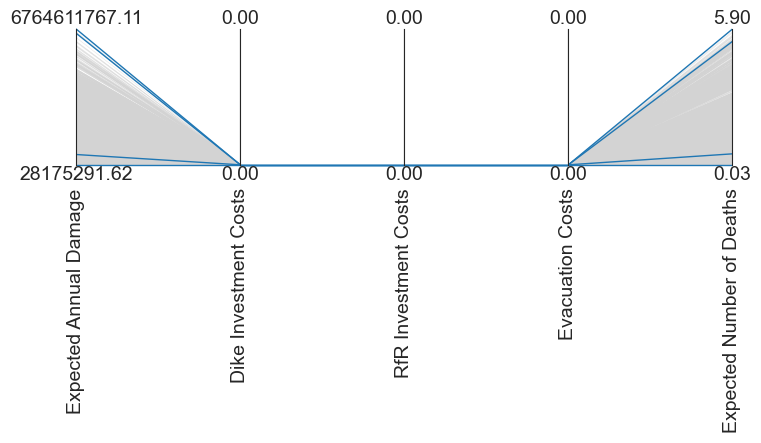

In [11]:
# acquire y dataframe
outcomes_data = pd.DataFrame({k:v for k,v in outcomes.items()})

# get the unique indices for the minima and maxima across
indices = pd.concat([outcomes_data.idxmax(), outcomes_data.idxmin()]).unique()

limits = parcoords.get_limits(outcomes_data)
axes = parcoords.ParallelAxes(limits)

# set the linewidth lower, and make the lines slightly transpartant using alpha
# this often helps reveal patterns in the results.
axes.plot(outcomes_data, color='lightgrey', lw=0.5, alpha=0.5)
axes.plot(outcomes_data.iloc[indices, :], color=sns.color_palette()[0], lw=1)

fig = plt.gcf()
fig.set_size_inches((8, 4))

# show the highlighted scenario among the set of outcomes
plt.show()

In [12]:
# show the worst and best case scenario
print(outcomes_data.idxmax())
print(outcomes_data.idxmin())

Expected Annual Damage       2032
Dike Investment Costs           0
RfR Investment Costs            0
Evacuation Costs                0
Expected Number of Deaths    3443
dtype: int64
Expected Annual Damage       1173
Dike Investment Costs           0
RfR Investment Costs            0
Evacuation Costs                0
Expected Number of Deaths    1173
dtype: int64


In [154]:
# get dataframe of the worst and best case scenario, refer to the index
selected = cleaned_experiments.loc[[2032, 3443, 1173]] #manual input
# show the selected scenario
selected

Fortunately only three scenarios identified using maxima and minima that are selected as the extreme scenario. Scenarios 2032 and 3443 are the worst case scenario for the Expected Number of Deaths, Expected Annual Damage, and RfR Investment Costs. These two scenarios are then archived as scenarios and used as the reference scenario to acquire the candidate solutions.

In [155]:
# convert the reference dataframe to scenario object
scenarios = [Scenario(f"{index}", **row) for index, row in selected.iterrows()]
scenarios

## 2.3 | Acquired candidate solutions for the reference scenario
The candidate solutions are acquired by running the direct search algorithm based on the reference scenario. The candidate solutions are the combination of the policy levers which can be used to evaluate the robustness of the policy levers.


In [156]:
# Specify the directory where log files should be stored
log_directory = './archive'

# Check if this directory exists
if not os.path.exists(log_directory):
    # If the directory doesn't exist, create it
    os.makedirs(log_directory)
else:
    # If 'tmp' subdirectory exists within the directory, remove it
    tmp_directory = os.path.join(log_directory, 'tmp')
    if os.path.exists(tmp_directory):
        shutil.rmtree(tmp_directory)

In [157]:
# establish the parameter to run the optimization
# establish the reference values
reference_values = {
        "Bmax": 175,
        "Brate": 1.5,
        "pfail": 0.5,
        "discount rate 0": 3.5,
        "discount rate 1": 3.5,
        "discount rate 2": 3.5,
        "ID flood wave shape": 4,
    }

# create the reference scenario
for key in dike_model.uncertainties:
    name_split = key.name.split("_")

    if len(name_split) == 1:
        # scenario[0] as the worst case scenario is the reference scenario,
        # acquired from the scenario object
        scenarios[0].update({key.name: reference_values[key.name]})

    else:
        scenarios[0].update({key.name: reference_values[name_split[1]]})

ref_scenario = Scenario("reference", **scenarios[0])

# establish the convergence metrics
convergence_metrics = [
    ArchiveLogger(
        log_directory,
        [l.name for l in dike_model.levers],
        [o.name for o in dike_model.outcomes],
        base_filename="archives_2.tar.gz", # the name of the archive file
        ),
    EpsilonProgress(),
]

# establish the epsilon values
espilon = [0.05] * (len(dike_model.outcomes))

# establish the number of function evaluations
nfe = 100000

As environmentalist group, Delta Commission, and Rijskwaterstaat favor the idea of having no damage and no death tolls, we will set the constraints to achieve 0 damage and 0 death tolls.

In [158]:
# establish the constraints. Environmental interest groups
# are not in favor to have damage and death tolls
# meaning that we want to achieve 0 damage and 0 death tolls

# summing up the expected annual damage and expected number of deaths
expected_annual_damage_list = [
    'A.{}_Expected Annual Damage'.format(i) for i in range(1, 6)
]
expected_number_of_deaths_list = [
    'A.{}_Expected Number of Deaths'.format(i) for i in range(1, 6)
]

combined_list = expected_annual_damage_list + expected_number_of_deaths_list

# the combined outcome should be 0
constraints = [Constraint("combined outcome constraint",
                          outcome_names= combined_list,
                          function=lambda *args: sum(args))]

In [ ]:
# Run the optimization based on the defined parameters, constrains, and reference scenario
with MultiprocessingEvaluator(dike_model) as evaluator:
# SequentialEvaluator is used for testing. MultiprocessingEvaluator can be implemented for actual use.
    results, convergence = evaluator.optimize(
        nfe=nfe,
        searchover="levers",
        epsilons=espilon,
        convergence=convergence_metrics,
        reference= ref_scenario,
        constraints= constraints
    )

In [25]:
# save the convergence tracker from the optimization
# convergence.to_csv('convergence_pf7_opt_nfe100k_eps05.csv')

In [159]:
# load the archives of the optimization progress
archives = ArchiveLogger.load_archives('./archive/archives_2.tar.gz')
for key, value in archives.items():
    print(f"Key: {key}, Number of rows: {value.shape[0]}")

In [ ]:
# Creating the DataFrame as result
# results = archives[100205]

# Save this DataFrame to a csv file for later us
results.to_csv("./archive/results_pf7_opt_nfe100k_eps05.csv")

In [160]:
# load the results from the previous experiments
results = pd.read_csv('./archive/results_pf7_opt_nfe100k_eps05.csv', index_col=0)

<Figure size 1000x2000 with 0 Axes>

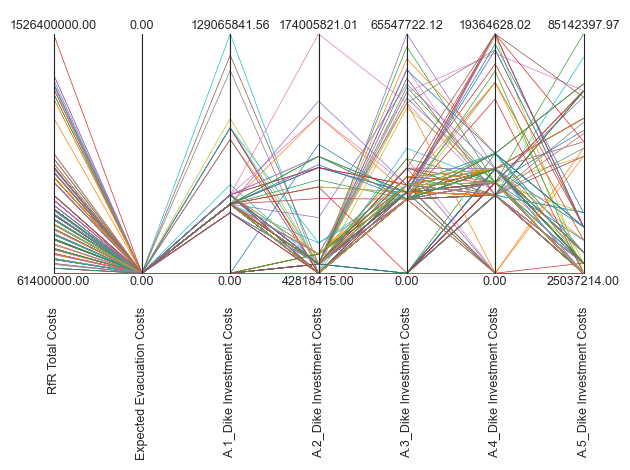

In [26]:
# select data
data = results.loc[:, ['RfR Total Costs', 'Expected Evacuation Costs',
                       'A.1_Dike Investment Costs', 'A.2_Dike Investment Costs',
                       'A.3_Dike Investment Costs', 'A.4_Dike Investment Costs',
                       'A.5_Dike Investment Costs']]
#data = results.loc[:, [o.name for o in dike_model.outcomes]]

limits = parcoords.get_limits(data)

# set plot size
plt.figure(figsize=(10, 20))

paraxes = parcoords.ParallelAxes(limits, fontsize=9)
paraxes.plot(data, linewidth=0.5)

# save the figure before showing it
plt.savefig("./figure/results_pf7_opt_nfe100k_eps05.png", dpi=300)

# show the plot
plt.show()

### Convergence analysis
How many function evaluations are needed to achieve the convergence of the $\epsilon$-NSGAII?
Below, we assess the convergence with showing the epsilon progress which measures how often a solution is found in a new grid cell of the epsilon gridded output space.Once the algorithm converge, the epsilon progress starts to stabilize.


In [161]:
# load results from the previous experiments
convergence_100 = pd.read_csv('./archive/convergence_pf7_opt_nfe100k_eps05.csv', index_col=0)
convergence_25 = pd.read_csv('./archive/convergence_pf7_opt_nfe25k_eps05.csv', index_col=0)

In [163]:
# Assess the plateau of the epsilon progress
y = np.array(convergence_100.epsilon_progress)
x = np.array(convergence_100.nfe)

# Compute the difference between successive y values
delta_y = np.diff(y)

# Set a threshold for what you consider a 'low' rate of change
threshold = 4

# Find where the absolute rate of change is below the threshold
plateaus = np.where(np.abs(delta_y) < threshold)

# 'plateaus' is now an array of indices where y is approximately constant
x_plateaus = x[plateaus]
y_plateaus = y[plateaus]
for xi, yi in zip(x_plateaus, y_plateaus):
    print(f'x: {xi}, y: {yi}')

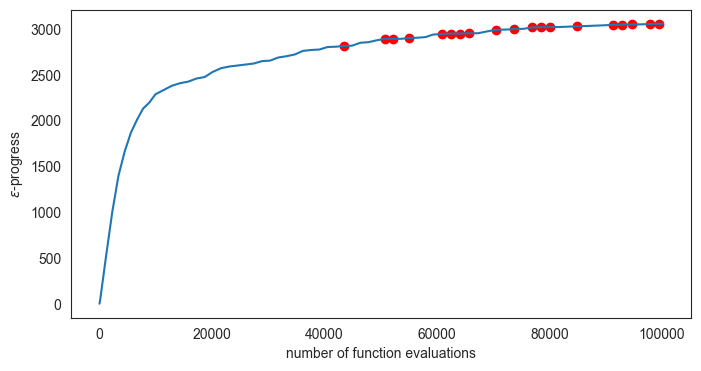

In [29]:
# visualise the epsilon progress, with spotting the plateau
fig, (ax1) = plt.subplots(ncols=1, sharex=True, figsize=(8,4))
ax1.plot(convergence_100.nfe, convergence_100.epsilon_progress)
ax1.set_ylabel('$\epsilon$-progress')
#ax2.plot(convergence_25.nfe, convergence_25.epsilon_progress)
#ax2.set_ylim(ymin=0)
#ax2.set_ylabel('$\epsilon$-progress')


ax1.set_xlabel('number of function evaluations')
#ax2.set_xlabel('number of function evaluations')

plt.scatter(x_plateaus, y_plateaus, color='red')

# save the figure before showing it
plt.savefig("./figure/epsilon_progress.png", dpi=300)

plt.show()

Based on the visualisation above, we can see that the epsilon progress starts to stabilize after 50,000 function evaluations. Therefore, we will use the results from the optimization with 100,000 function evaluations.

# 3| Reevaluate candidate solution in deep uncertainty
Based on the candidate solution from directed search, environmentalist group can select the preferred policy based on the interest. Although it is not captured explicitly by the model, strong interest in having RfR as the solution is implemented as the filter of the preferred policy. Additionally, global sensitivity analysis unveils that outcomes of interest are sensitive to the decision in having Room for the River in dike ring 1 at time planning 1 (0_RfR 1). This helps environmentalist group to prioritize the dike ring 1 to be implemented.

Furthermore, minimise the implementation of dike heightening is considered in selecting the preferred candidate solutions. This is because the environmentalist group, according to the negotiation with Rijskwaterstaat and Delta Commission, is not in favor of having high dike heightening as it will cause damage to the environment.

To evaluate the robustness of the preferred candidate solution, maximum regret metrics is used. Regret compares outcome under the chosen candidate solution, which we called preferred candidate solution, with the best outcome could have been achieved under any other candidate solution, given the same scenario. Hence, maximum regret is the highest regret across all considered scenarios for a given policy.

## 3.0| Select the preferred candidate solution and run the experiments
Preferred candidate solution is selected based on the following criteria:
- RfR is implemented in dike ring 1 at time planning 1 (0_RfR 1)
- RfR investments costs is greater than total dike investments costs


In [45]:
# load the results from the previous experiments
results = pd.read_csv('./archive/results_pf7_opt_nfe100k_eps05.csv', index_col=0)

In [46]:
# establish a set of preferred policies
# based on sensitivity analysis, we prioritise 0_RfR 1 to be implemented
policies = results[results['0_RfR 1'] == 1]
# get a boolean Series where each value represents whether policy
# has less RfR than dike heightening, meaning that the RfR is prioritised
rfr_less_dike = (policies['A.1_Dike Investment Costs']
                 + policies['A.2_Dike Investment Costs']
                 + policies['A.3_Dike Investment Costs']
                 + policies['A.4_Dike Investment Costs']
                 + policies['A.5_Dike Investment Costs']
                 < policies['RfR Total Costs'])

# use this boolean Series to filter the DataFrame
policies = policies[rfr_less_dike]
policies

,Unnamed: 0,0_RfR 0,0_RfR 1,0_RfR 2,1_RfR 0,1_RfR 1,1_RfR 2,2_RfR 0,2_RfR 1,2_RfR 2,...,A.3_Expected Annual Damage,A.3_Expected Number of Deaths,A.4_Dike Investment Costs,A.4_Expected Annual Damage,A.4_Expected Number of Deaths,A.5_Dike Investment Costs,A.5_Expected Annual Damage,A.5_Expected Number of Deaths,RfR Total Costs,Expected Evacuation Costs
58,58,0,1,0,0,0,0,1,1,0,...,0.0,0.0,1.544456e+07,0.0,0.0,2.757823e+07,0.0,0.0,388400000.0,0.0
100,100,0,1,0,0,0,0,0,1,0,...,0.0,0.0,7.332080e+06,0.0,0.0,2.757823e+07,0.0,0.0,478900000.0,0.0
130,130,0,1,0,0,0,0,1,1,1,...,0.0,0.0,8.453408e+06,0.0,0.0,3.667668e+07,0.0,0.0,297900000.0,0.0


In [47]:
# get the policies levers
policies = policies.loc[:, [l.name for l in dike_model.levers]]
policies

,0_RfR 0,0_RfR 1,0_RfR 2,1_RfR 0,1_RfR 1,1_RfR 2,2_RfR 0,2_RfR 1,2_RfR 2,3_RfR 0,...,A.2_DikeIncrease 2,A.3_DikeIncrease 0,A.3_DikeIncrease 1,A.3_DikeIncrease 2,A.4_DikeIncrease 0,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2
58,0,1,0,0,0,0,1,1,0,0,...,0,1,0,0,3,0,1,2,0,0
100,0,1,0,0,0,0,0,1,0,1,...,0,2,0,0,2,0,0,2,0,0
130,0,1,0,0,0,0,1,1,1,0,...,0,1,0,0,3,0,0,5,0,0


In [48]:
# from a set of preferred policy, get the policies as dictionary
policies_to_evaluate = []

for i, policy in policies.iterrows():
    policies_to_evaluate.append(Policy(str(i), **policy.to_dict()))

In [ ]:
# run the experiments
n_scenarios = 5000
with MultiprocessingEvaluator(dike_model) as evaluator:
    results = evaluator.perform_experiments(n_scenarios,
                                            policies_to_evaluate)

In [ ]:
experiments, outcomes = results
outcomes

In [ ]:
# export results
save_results((experiments, outcomes), './archive/results_scenario_disc_pf7_15k.tar.gz')

In [49]:
# load results
results = load_results('./archive/results_scenario_disc_pf7_15k.tar.gz')

[MainProcess/INFO] results loaded successfully from C:\Users\Almira\OneDrive - Delft University of Technology\Q4\Model-based decision making\epa1361_open\final assignment\archive\results_scenario_disc_pf7_15k.tar.gz


In [51]:
experiments, outcomes = results

## 3.1| Regret analysis
After the preferred candidate solution is selected, we can compare the regret between the preferred candidate solution. We favor the preferred candidate solution with the minimum of the maximum regret.

In [52]:
# load results
results = load_results('./archive/results_scenario_disc_pf7_15k.tar.gz')
experiments, outcomes = results

[MainProcess/INFO] results loaded successfully from C:\Users\Almira\OneDrive - Delft University of Technology\Q4\Model-based decision making\epa1361_open\final assignment\archive\results_scenario_disc_pf7_15k.tar.gz


In [53]:
# function to calculate regret
def calculate_regret(data, best):
    return np.abs(best-data)

In [54]:
overall_regret = {}
max_regret = {}
for outcome in dike_model.outcomes:
    policy_column = experiments['policy']

    # create a DataFrame with all the relevent information
    # i.e., policy, scenario_id, and scores
    data = pd.DataFrame({outcome.name: outcomes[outcome.name],
                         "policy":experiments['policy'],
                         "scenario":experiments['scenario']})

    # reorient the data by indexing with policy and scenario id
    data = data.pivot(index='scenario', columns='policy')

    # flatten the resulting hierarchical index resulting from
    # pivoting, (might be a nicer solution possible)
    data.columns = data.columns.get_level_values(1)

    outcome_regret = (data.max(axis=1).values[:, np.newaxis] - data).abs()

    overall_regret[outcome.name] = outcome_regret
    max_regret[outcome.name] = outcome_regret.max()

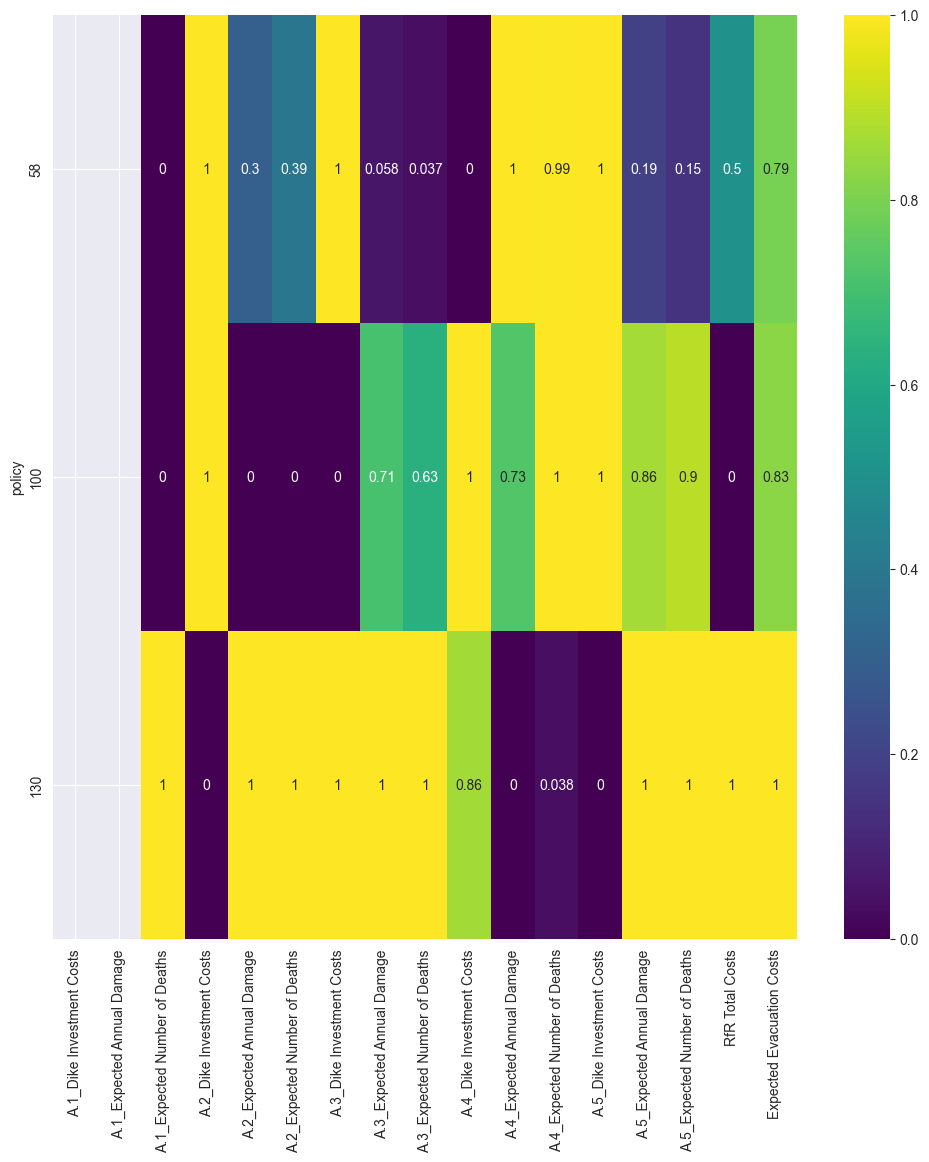

In [55]:
# visualise the regret
max_regret = pd.DataFrame(max_regret)
plt.figure(figsize=(12, 12))
sns.heatmap(max_regret/max_regret.max(), cmap='viridis', annot=True)

# save the figure before showing it
plt.savefig("./figure/regret.png", dpi=300, bbox_inches='tight')
plt.show()

This result shows tradeoff. It is obvious that there is tradeoff between Expected Annual Damage in Dike Ring 2 and Expected Number of Deaths in the Dike Ring 1 and versus Dike Investment Cost in Dike Ring 2. Given this tradeoff, we can select preferred candidate solution with the least maximum regret, which in this case is policy 100 and 58.

# 4| Scenario discovery
## 4.0| Pattern discovery
This section dedicates to spotting patterns or trends that might not be immediately obvious in raw data.

In [ ]:
# create a histogram of the outcomes
outcomes.hist(grid = False, figsize= [15,15])

# save the figure before showing it
plt.savefig("./figure/scenario_discovery_hist.png", dpi=300)

plt.tight_layout(w_pad=0.5, h_pad=1.0)
plt.show()

In [63]:
# aggregate the outcomes of interest
data = outcomes.copy()
data['Expected Annual Damage'] = data[['A.1_Expected Annual Damage',
                                    'A.2_Expected Annual Damage',
                                    'A.3_Expected Annual Damage',
                                    'A.4_Expected Annual Damage',
                                    'A.5_Expected Annual Damage']].sum(axis=1)
data['Total Dike Investment Costs'] = data[['A.1_Dike Investment Costs',
                                            'A.2_Dike Investment Costs',
                                            'A.3_Dike Investment Costs',
                                            'A.4_Dike Investment Costs',
                                            'A.5_Dike Investment Costs']].sum(axis=1)
data['Expected Number of Deaths'] = data[['A.1_Expected Number of Deaths',
                                            'A.2_Expected Number of Deaths',
                                            'A.3_Expected Number of Deaths',
                                            'A.4_Expected Number of Deaths',
                                            'A.5_Expected Number of Deaths']].sum(axis=1)

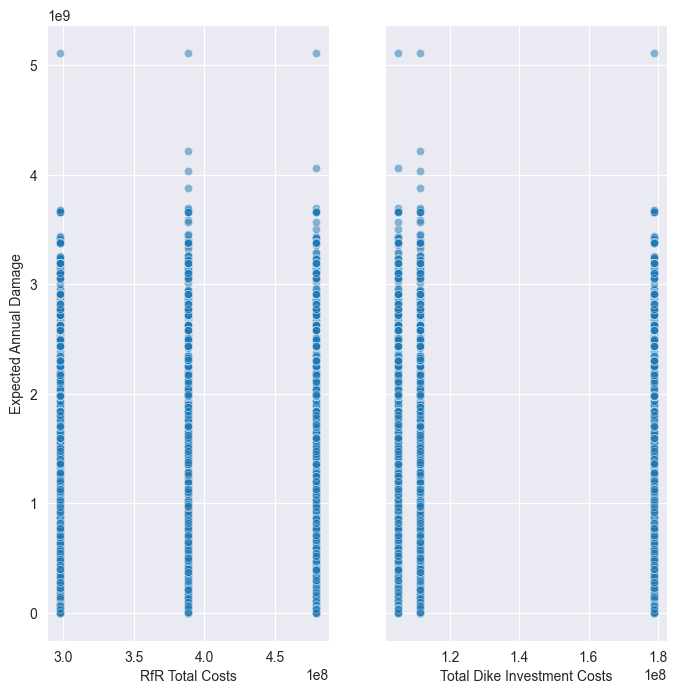

In [7]:
# plot the outcomes how RfR and Dike Investment Costs
# affect the Expected Annual Damage
fig, ax = plt.subplots(nrows=1, ncols= 2,sharey=True, figsize = (8,8))

sns.scatterplot(data=data, y ='Expected Annual Damage',
                x = 'RfR Total Costs',
                alpha = 0.5, ax=ax[0])
sns.scatterplot(data=data, y ='Expected Annual Damage',
                x = 'Total Dike Investment Costs',
                alpha = 0.5, ax=ax[1])

# save the figure before showing it
plt.savefig("./figure/scenario_discovery_damage_rfr_dh.png", dpi=300)

plt.show()

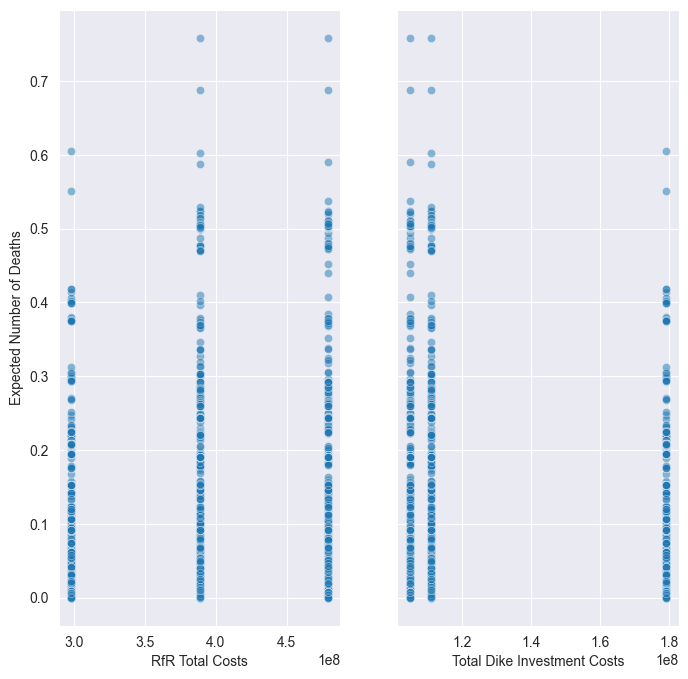

In [8]:
# plot the outcomes how RfR and Dike Investment Costs
# affect the Expected Number of Deaths
fig, ax = plt.subplots(nrows=1, ncols= 2,sharey=True, figsize = (8,8))

sns.scatterplot(data=data, y ='Expected Number of Deaths',
                x = 'RfR Total Costs',
                alpha = 0.5, ax=ax[0])
sns.scatterplot(data=data, y ='Expected Number of Deaths',
                x = 'Total Dike Investment Costs',
                alpha = 0.5, ax=ax[1])

# save the figure before showing it
plt.savefig("./figure/scenario_discovery_deaths_rfr_dh.png", dpi=300)

plt.show()

## 4.1| Scenario discovery with PRIM of Policy 100
Previous section unveils that Policy#100 may be the favourable policy among a set of preferred candidate policy. In this section, we will use PRIM to discover the scenarios to support the confidence level of Policy#100.

In [95]:
# Separate the data for each policy
x_58 = experiments.iloc[0:5000, ]
x_100 = experiments.iloc[5000:10000, ]
x_130 = experiments.iloc[10000:15000, ]

y_58 = data.iloc[0:5000, ]
y_100 = data.iloc[5000:10000, ]
y_130 = data.iloc[10000:15000, ]

In [106]:
# filter dataframe with only uncertainties
x = x_100.drop(labels=[l.name for l in dike_model.levers], axis=1)
x.drop(columns= ['scenario', 'policy', 'model'], inplace= True)

### 4.1.1| The condition where expected damages greater than total investment costs
The expected damages is greater than total investment costs is the condition where the investment is not effective to reduce damages. Therefore, this condition is the condition where the policy is not favourable.  In this case, we will use PRIM to discover the scenarios where the expected damages is greater than total investment costs.

In [181]:
# set the outcome of interest
y = ((y_100['RfR Total Costs'] +
      y_100['Total Dike Investment Costs'] +
      y_100['Expected Evacuation Costs'])
     < y_100['Expected Annual Damage'])
y = y.reset_index(drop=True)

In [182]:
# pas the parameters to PRIM and run PRIM
prim_alg = prim.Prim(x, y, threshold=0.5, peel_alpha=0.1)

# find the box
box = prim_alg.find_box()

[MainProcess/INFO] 5000 points remaining, containing 1033 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.166, coverage: 0.8034849951597289, density: 1.0 restricted_dimensions: 1


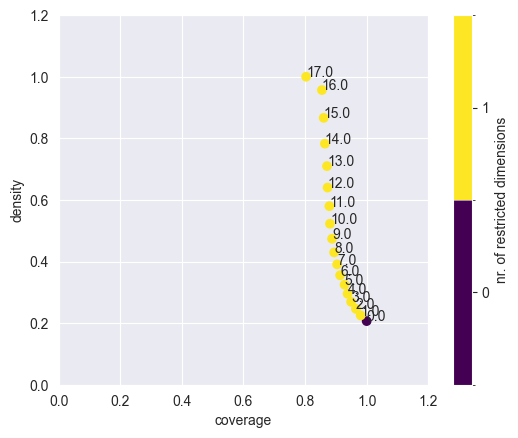

In [183]:
# evaluate the tradeoff
box.show_tradeoff(annotated=True)

plt.savefig("./figure/prim1_tradeoff_p100.png", dpi=300)

In [184]:
# select the favourable box to inspect
point = 15

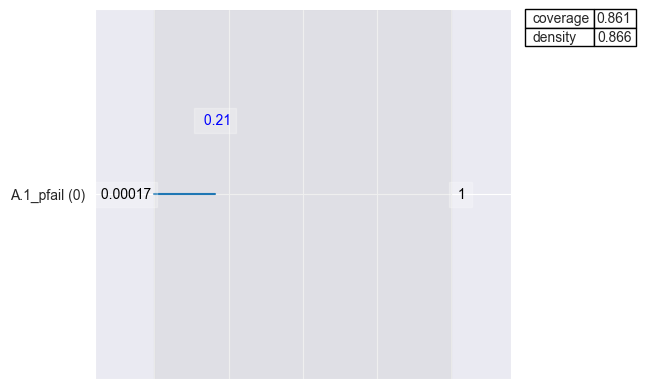

In [185]:
# inspect the box
box.inspect(point, style='graph')
# save the figure before showing it
plt.savefig("./figure/prim1_inspect_p100.png", dpi=300, bbox_inches='tight')
plt.show()

### 4.1.2| The condition where expected number of deaths is greater than 0.2
The expected causalities is greater than 0.2 or the condition where the policy is not effective to reduce the causalities. Therefore, this condition is the condition where the policy is not favourable.  In this case, we will use PRIM to discover the scenarios where the expected damages is greater than total investment costs.

In [186]:
# set the outcome of interest
y = ((y_100['Expected Number of Deaths'])
     > 0.2)
y = y.reset_index(drop=True)

# ensure the outcome of interest is available
num_false = (y == True).sum()
num_false

792

In [187]:
# perform PRIM
prim_alg = prim.Prim(x, y, threshold=0.5, peel_alpha=0.1)
# find the box
box = prim_alg.find_box()

[MainProcess/INFO] 5000 points remaining, containing 792 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.1344, coverage: 0.8484848484848485, density: 1.0 restricted_dimensions: 1


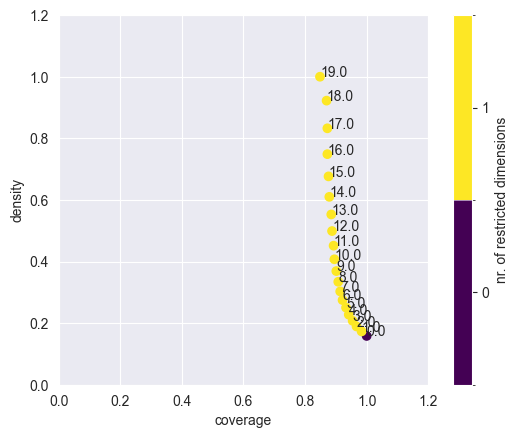

In [188]:
# show the tradeoff
box.show_tradeoff(annotated=True)

plt.savefig("./figure/prim2_tradeoff_p100.png", dpi=300)

In [189]:
# select the box of interest to inspect
point = 18

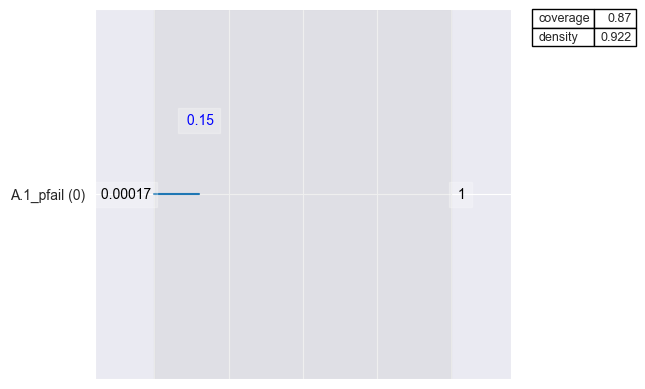

In [190]:
# inspect the box
box.inspect(point, style='graph')
# save the figure before showing it
plt.savefig("./figure/prim2_inspect_p100.png", dpi=300,bbox_inches='tight')
plt.show()

### 4.1.3| The condition where expected number of deaths is lower than 0.1
The expected causalities is lower than 0.1 or the condition where the policy is effective to reduce the causalities. Therefore, this condition is the condition where the policy is favourable.

In [191]:
# set the outcome of interest
y = ((y_100['Expected Number of Deaths'])
     < 0.1)
y = y.reset_index(drop=True)

# ensure the outcome of interest is available
num_false = (y == True).sum()
num_false

4030

In [192]:
# perform PRIM
prim_alg = prim.Prim(x, y, threshold=0.5, peel_alpha=0.1)
box = prim_alg.find_box()

[MainProcess/INFO] 5000 points remaining, containing 4030 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.656, coverage: 0.8138957816377171, density: 1.0 restricted_dimensions: 3


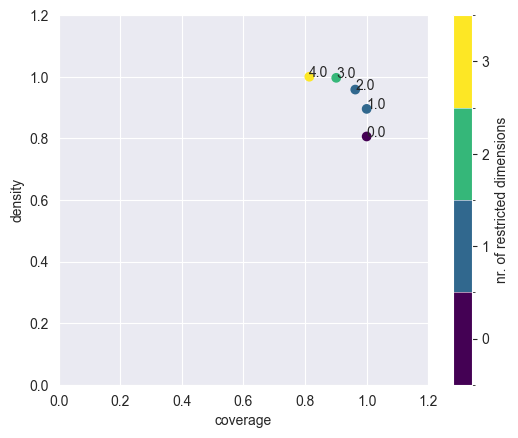

In [193]:
#show the tradeoff
box.show_tradeoff(annotated=True)
plt.savefig("./figure/prim3_tradeoff_p100.png", dpi=300)

In [194]:
# set the box of interest to inspect
point = 4

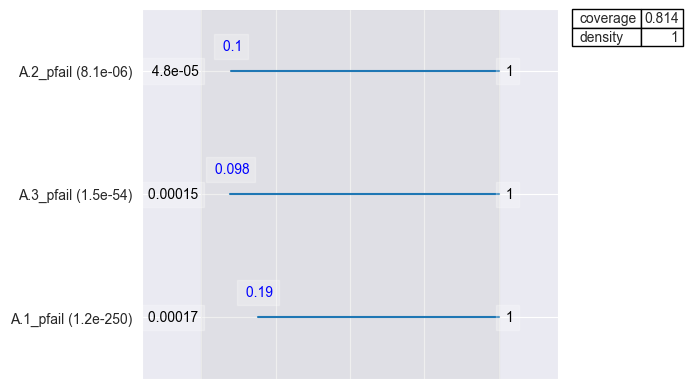

In [195]:
# inspect the box
box.inspect(point, style='graph')
# save the figure before showing it
plt.savefig("./figure/prim3_inspect_p100.png", dpi=300,bbox_inches='tight')
plt.show()

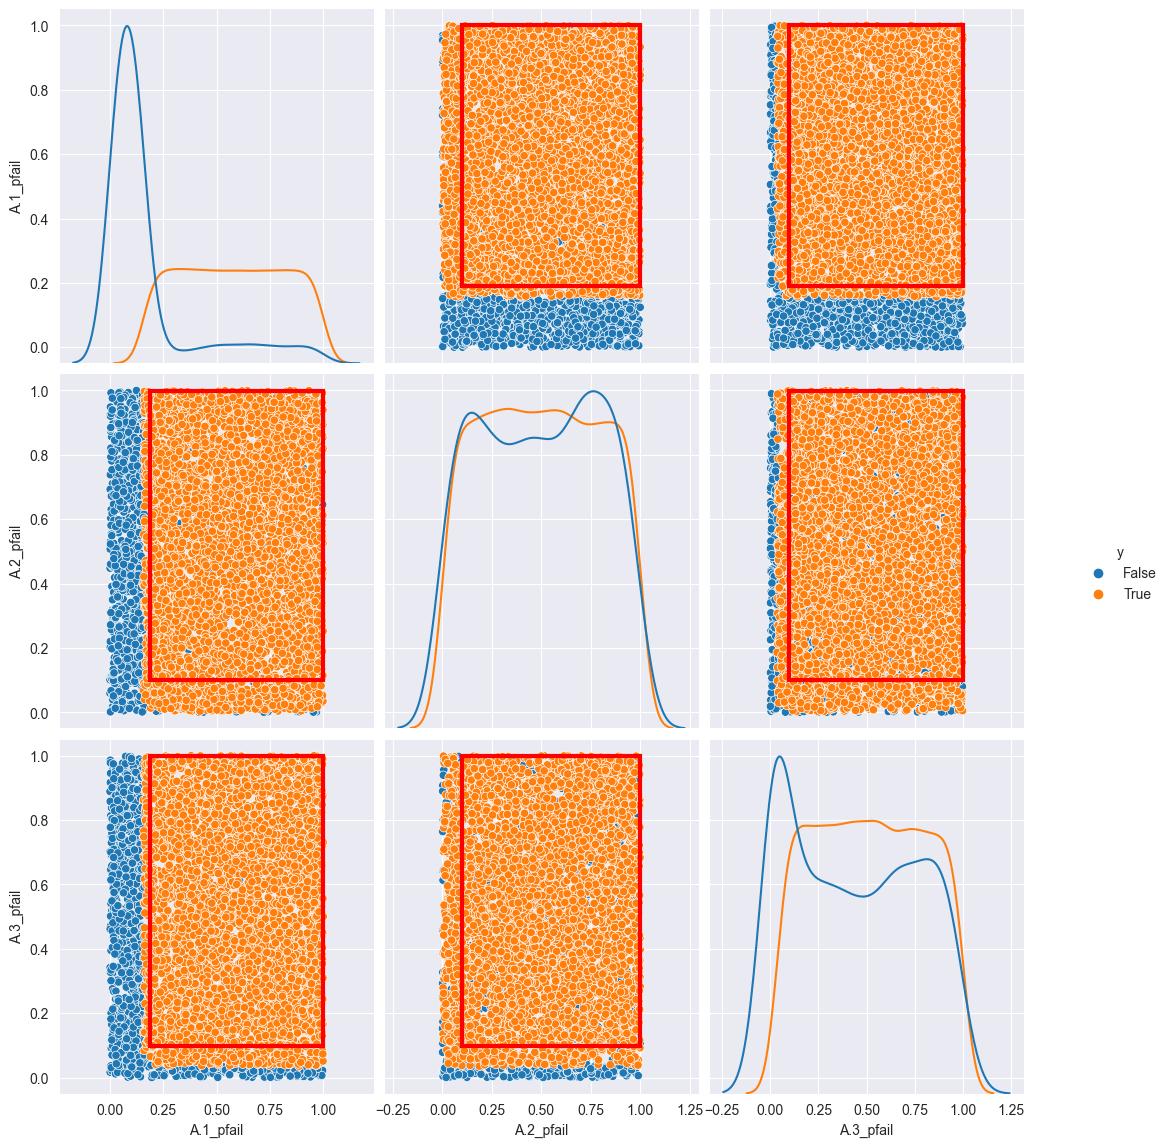

In [161]:
# get the distribution of the data in the box
box.select(point)
box.show_pairs_scatter()
fig = plt.gcf()
fig.set_size_inches(12,12)
plt.show()

### 4.1.4| The condition where expected damages lower than total investment costs
The expected damages is lower than total investment costs is the condition where the investment is effective to reduce damages. Therefore, this condition is the condition where the policy is favourable.

In [176]:
# set the outcome of interest
y = ((y_100['RfR Total Costs'] +
      y_100['Total Dike Investment Costs'] +
      y_100['Expected Evacuation Costs'])
     > y_100['Expected Annual Damage'])
y = y.reset_index(drop=True)

# ensure the outcome of interest is available
num_false = (y == True).sum()
num_false

3967

In [177]:
# perform PRIM
prim_alg = prim.Prim(x, y, threshold=0.5, peel_alpha=0.1)

# find the box
box = prim_alg.find_box()

[MainProcess/INFO] 5000 points remaining, containing 3967 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.5904, coverage: 0.7441391479707588, density: 1.0 restricted_dimensions: 4


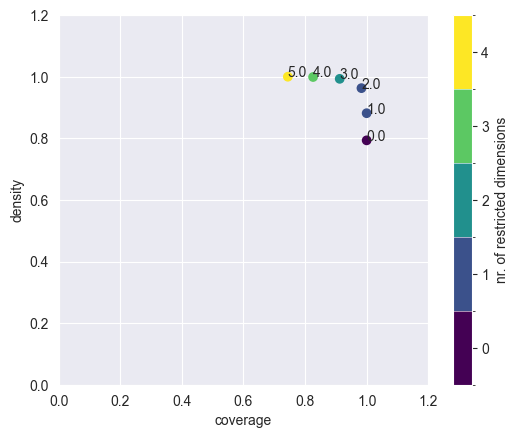

In [178]:
# show the tradeoff
box.show_tradeoff(annotated=True)
plt.savefig("./figure/prim4_tradeoff_p100.png", dpi=300)

In [179]:
# set the box of interest to inspect
point = 3

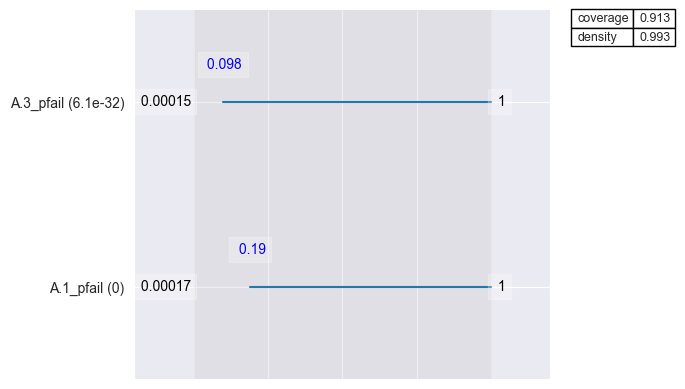

In [180]:
# inspect the box
box.inspect(point, style='graph')
# save the figure before showing it
plt.savefig("./figure/prim4_inspect_p100.png", dpi=300,bbox_inches='tight')
plt.show()

# Remarks
This notebook go through the process of finding the preferred candidate solution, which is the policy for flood risk in Ijssel River, and discover the condition or scenario where the policy is vulnerable. Each step of the process unveil the assumptions to acquire the policy which if the assumption is changed, it may results in different set of candidate solutions.
